# 第9回 一般化線形モデル


[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slt666666/biostatistics_text_wed/blob/main/source/_static/colab_notebook/chapter9.ipynb)

※Web上ではテーブルや記号など一部LaTeXが反映されず見にくくなってしまっていますが、Google Colabだとちゃんと見えます。

## はじめに

これまで扱ってきた統計検定手法や回帰分析などは、データが**正規分布**に従っているものが殆どでした。

多くの生物学的な現象は確かに正規分布に従っていることが多いので、これまでに扱ってきた手法が適用されることが多いのですが、

当然ながら正規分布に従わず、ポアソン分布や二項分布など、別の確率分布に従うと考えた方が適切な現象も存在します。

その場合には、前回扱った回帰分析とは違った**一般化線形モデル**などを用いることがあります。

本項では、正規分布以外の確率分布のパラメータ推定や、一般化線形モデルを扱います。

## 一般化線形モデルとは？

まず、これまで回帰分析などで扱ってきたモデル

$Y_i = \beta_1 + \beta_2X_i + \epsilon_i$

は、$\epsilon_i$が正規分布に従っている場合、最小二乗法によって、$\hat{\beta_1}, \hat{\beta_2}$が求まりました。

これは$\epsilon_i$**が正規分布に従っている**ということを仮定においています。

つまり、"切片と説明変数の線形和で説明しきれない部分は、正規分布に従ってばらつくと考えられる"ということを示しています。

<img src="https://github.com/slt666666/biostatistics_text_wed/blob/main/source/_static/images/chapter9/lm.png?raw=true" alt="title" height="250px">

この$\epsilon_i$**が正規分布に従っている**ということを仮定においたモデルを**一般線形モデル**(**線形モデル**)と呼びます。

分散分析や$t$検定なども一般線形モデルの枠組みで扱う事が出来ます。

ではこの仮定($\epsilon_i$**が正規分布に従っている**)に合わない場合はどうなるでしょうか。

例えば下図のような場合、左の様に正規分布を仮定した場合よりも、右の様にポアソン分布を仮定した方が当てはまりがよさそうです。

しかし、正規分布を仮定しない場合は、線形モデルでは扱う事が出来ません。

<img src="https://github.com/slt666666/biostatistics_text_wed/blob/main/source/_static/images/chapter9/lm_poisson.png?raw=true" alt="title" height="250px">

こうした問題に対応するために、一般線形モデルを拡張する必要があります。

一般線形モデルは残差の分布が正規分布に限られていましたが、

これを「正規分布以外」の二項分布やポアソン分布等も扱える様に拡張したモデルが**一般"化"線形モデル**(Genelarized Linear Model, GLM)になります。

この時、最小二乗法ではパラメータ$\beta$の推定が出来ないことが多いので、

確率分布に基づいた**最尤法**という手法を用いて回帰モデルを推定する必要があります。

### 二項分布の場合

まずは二項分布の例を使って一般化線形モデルについて触れていきます。

例えば下の様なデータがあったとします。

ある土壌栄養の条件(`nutrition`)における種子の発芽率(`rate`)を示しています。

調査は全て10個の種を使用し(`size`)、発芽した種の数は`germination`で表されています。

In [ ]:
# 各肥料条件における発芽率のデータ
data <- read.csv("https://raw.githubusercontent.com/slt666666/biostatistics_text_wed/refs/heads/main/source/_static/data/chapter9_germination1.csv")
# データの一部を表示
head(data)

,germination,size,germination_rate,nutrition
,<int>,<int>,<dbl>,<dbl>
1,0,10,0.0,1.113
2,1,10,0.1,1.411
3,0,10,0.0,1.162
4,0,10,0.0,1.181
5,0,10,0.0,1.422
6,0,10,0.0,2.237


土壌栄養と発芽率の関係性を統計モデルとして捉えようと考えた際に、これまで通り線形モデルを適用してみます。

簡易的に`ggplot`で回帰直線を描いてみると…

Warning message in geom_smooth(method = "lm", fomula = "y~x"):
“Ignoring unknown parameters: `fomula`”
`geom_smooth()` using formula = 'y ~ x'


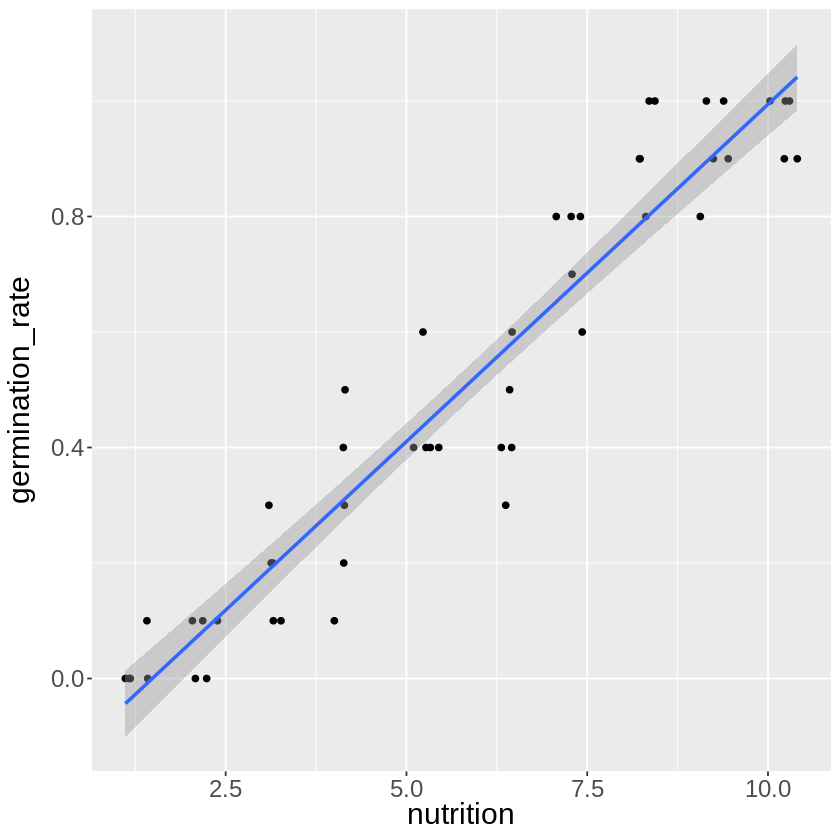

In [ ]:
# ggplotで発芽率と施肥量の回帰直線を描く
library(ggplot2)
g <- ggplot(data,aes(x=nutrition, y=germination_rate))
g <- g + geom_point()
g <- g + geom_smooth(method="lm",fomula='y~x')
g <- g + theme(text = element_text(size = 18))
plot(g)

この様に一見うまく関係性を説明できていそうな直線が完成します。

発芽率$p = \beta_0 + \beta_1x$の様な形です。

しかし、この回帰直線に基づくと、栄養成分が$0$の時発芽率がマイナス$\%$になっており、

逆に栄養成分が$10$以上の時、発芽率は$100\%$を超えるというあり得ない数値になってしまいます。

この場合は、左図の様に線形回帰ではなく、最小値が$0$,最大値が$1$となるような右図の様な回帰が正しそうです。

<img src="https://github.com/slt666666/biostatistics_text_wed/blob/main/source/_static/images/chapter9/over100.png?raw=true" alt="title" height="350px">

では右図の様な回帰をどのように行っていくかについて学んでいきます。

#### ロジット変換

この時用いられるのが**ロジット変換**と呼ばれる方法になります。

今回の発芽率の様な確率$p$は$0 \sim 1$の範囲の値しかとらないですが、

この値をロジット$logit(p) = log\dfrac{p}{1-p}$に変換することで、$(-\infty \sim \infty)$の値をとるように変換することが出来ます。

そのため、このロジットには線形モデルを仮定しても先ほどの様な不合理性が生じないことになります。

$logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1x$

新たな目的変数に変換することで線形モデルで説明することが可能になるので、

あとはこれまでと同じようにパラメータ$\beta$を推定すれば良いというわけです。

このように、一般の回帰曲線の式を線形の式に変形するような関数、

今回であればロジット関数$logit(p) = log(\dfrac{p}{1-p})$を**リンク関数**と呼びます。

また、$\beta_0+\beta_1x$の部分を**線形予測子**と呼びます。

<img src="https://github.com/slt666666/biostatistics_text_wed/blob/main/source/_static/images/chapter9/link_function.png?raw=true" alt="title" height="150px">

ロジット関数の逆関数を求めると、

$p = \dfrac{e^{\beta_0+\beta_1x}}{1 + e^{\beta_0+\beta_1x}} = \dfrac{1}{1 + e^{-(\beta_0+\beta_1x)}}$ となるので、

$g(x) = \dfrac{1}{1 + e^{-(\beta_0+\beta_1x)}}$と表される関数を**ロジスティック関数**と呼びます。

この関数の形を見てみましょう。

Rの`stat_function`という関数を使うと、任意の数式をグラフ化する事が出来ます。

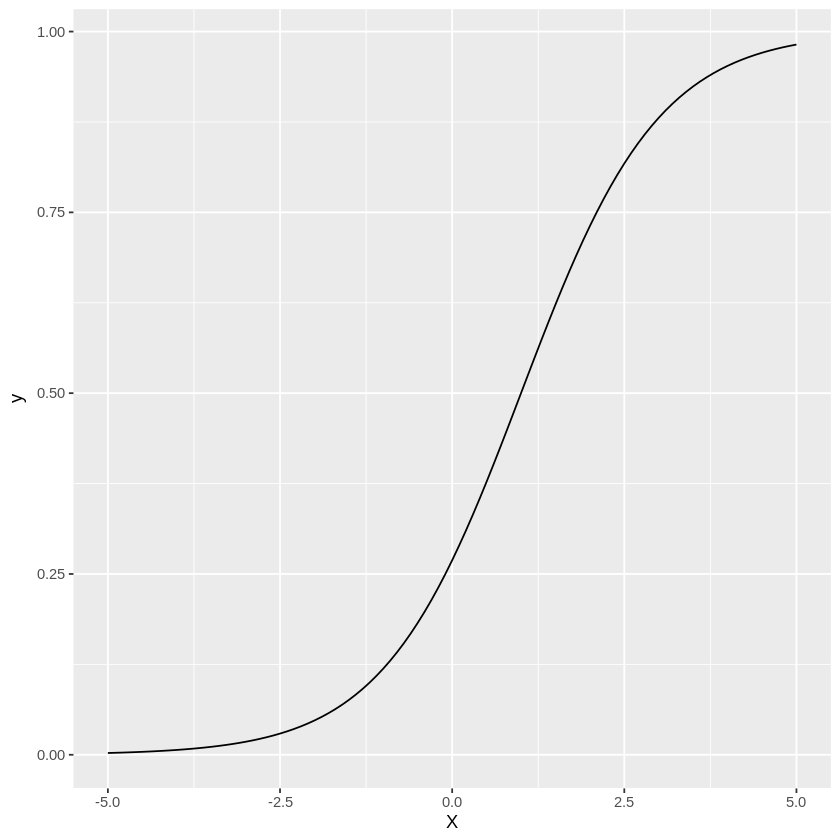

In [ ]:
# ロジスティック関数を可視化する
library(ggplot2)

beta0 <- -1
beta1 <- 1

g <- ggplot(data=data.frame(X=c(-5,5)), aes(x=X))
g <- g + stat_function(fun=function(x) 1/(1+exp(-(beta0+beta1*x))))
g

ロジスティック関数によって、求めていた$0 \sim 1$の範囲に留まる曲線が描けているのが分かるかと思います。

パラメータ$\beta_0, \beta_1$の値によって形が変わってくるので、あとは得られたデータに合うように$\beta_0, \beta_1$を推定していきます。

#### 最尤法 (most likelihood method)

線形モデルでは、予測からのデータの残差が最小になるようにパラメータを推定する最小二乗法を用いていました。

しかしこの方法は、残差が正規分布に従うことを仮定した方法だったので、今回は使用できません。

そこで**最尤法**という手法でパラメータを推定します。

最尤法は、手元の観測データを最も高い確率で再現できるモデルを探索してパラメータを決める方法になります。

得られた観測データに対し最も尤もらしい(もっともらしい)モデルを求める、という意味になります。

具体的に見ていくと、例えば今回下記の様なデータが得られていたとします。

\begin{array}{c|ccc} \hline
   観測データ & 発芽種子数 & 未発芽種子数 & 発芽率 & 栄養成分 \\ \hline
   A & 1 & 9 & 0.1 & 1.411 \\
   B & 6 & 4 & 0.6 & 5.229 \\
   C & 9 & 1 & 0.9 & 9.45 \\ \hline
\end{array}

栄養成分$1.411$の時に発芽する確率を$p_A$とおくと、観測データAが生じる確率は、二項分布より

* $_1C_{10}\times p_A^1\times(1-p_A)^9$

と計算できます。同様に、観測データBやCが生じる確率はそれぞれ

* $_6C_{10}\times p_B^6\times(1-p_B)^4$

* $_9C_{10}\times p_C^9\times(1-p_C)^1$

と計算できます。

先ほどのロジット関数の逆関数より、$p = \dfrac{1}{1 + e^{-(\beta_0+\beta_1x)}}$となるので、各観測値における施肥量から

$p_A = \dfrac{1}{1 + e^{-(\beta_0+\beta_1 \times 1.14)}}$、$p_B = \dfrac{1}{1 + e^{-(\beta_0+\beta_1 \times 5.229)}}$、$p_C = \dfrac{1}{1 + e^{-(\beta_0+\beta_1 \times 9.45)}}$

となり、観測データA,B,Cが生じる確率は$\beta_0, \beta_1$の関数となることが分かります。

観測データAが生じる確率$\times$観測データBが生じる確率$\times$観測データCが生じる確率が最大になる、つまり

$p_A^1\times(1-p_A)^9 \times p_B^6\times(1-p_B)^4 \times p_C^9\times(1-p_C)^1$

が最大になる様な$\beta_0, \beta_1$を求めるのが最尤法となります。

<br>

もう少し一般化すると、観測データが$n$得られている場合、

各観測データにおける発芽した種子数を$y_i$, 発芽しなかった種子数を$10 - y_i$, 発芽する確率を$p_i$とすると、

各観測データが生じる確率の積は

$L = \prod_{i=1}^{n}p_i^{y_i}(1-p_i)^{10 - y_i}$

と表すことが出来ます。各観測値が起きうる確率の積$L$を**尤度**と呼びます。

<br>

この尤度が最大になるパラメータを求めることになりますが、

積の数がとても多いので対数をとり、和の形に変換します。

$log(L) = log(\prod_{i=1}^{n}p_i^{y_i}(1-p_i)^{10 - y_i}) $

$= \sum_{i=1}^{n}\lbrace y_i log(p_i)+(10-y_i)log(1-p_i)\rbrace$

この対数を取った尤度$log(L)$を**対数尤度**と呼びます。

<br>

$p = \dfrac{1}{1 + e^{-(\beta_0+\beta_1x)}}$を対数尤度の関数に代入し、尤度(対数尤度)を最大にするパラメータ(今回は$\beta_0, \beta_1$)の値を計算します。

計算によって算出されたパラメータ($\hat{\beta_0}, \hat{\beta_1}$)を**最尤推定量**と呼びます。

最尤推定量は、標本サイズが大きくなるにつれて、真のパラメータに確率収束していく一致性という性質や、

線形不偏推定量の中で分散が最も小さい推定量という性質を持ち、観測されたデータから元となる母集団を推定しようとする際に広く用いられる推定量になります。

<br>

最尤推定量は偏微分$\dfrac{\partial}{\partial \beta_0}log(L) = 0$や、$\dfrac{\partial}{\partial \beta_1}log(L) = 0$を解くことで得る事が出来ますが、

(※厳密にはロジスティック関数の場合は最尤推定量が解析的に求められないので、ニュートンラフソン法等を使い数値的に求める必要があります。)

これもRの関数を用いて簡単に算出することが可能です。





In [ ]:
# データの表示
head(data)

,germination,size,germination_rate,nutrition
,<int>,<int>,<dbl>,<dbl>
1,0,10,0.0,1.113
2,1,10,0.1,1.411
3,0,10,0.0,1.162
4,0,10,0.0,1.181
5,0,10,0.0,1.422
6,0,10,0.0,2.237


$logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分$

として、発芽率を栄養成分によって説明するモデルを考えた場合、

今回のデータ50個の観測値を生じさせる確率が最も高くなるパラメータ$\beta_0, \beta_1$を求めます。

この時、一般化線形モデルを扱うことが可能な`glm`関数を用いて最尤推定量を求めます。

`glm`関数は下記の様に、モデル式やリンク関数などを指定して使用します。

```
result <- glm(モデル式, family = 目的変数の分布(link = リンク関数), data = データフレーム)
summary(result)
```

線形回帰`lm`の時と同じように`summary`関数を用いて結果を詳細に表示します。

※少しややこしいですが、モデル式の中で、目的変数として発芽数(`germination`)と、試行回数(`size`)から発芽数を引いた値(`size - germination`)を`cbind`を使って組み込んでいます。

In [ ]:
# glm関数を用いて最尤推定を行う。
result <- glm(cbind(germination, size - germination) ~ nutrition, family = binomial, data = data)
summary(result)


Call:
glm(formula = cbind(germination, size - germination) ~ nutrition, 
    family = binomial, data = data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.03768    0.35390  -11.41   <2e-16 ***
nutrition    0.69792    0.05714   12.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 317.356  on 49  degrees of freedom
Residual deviance:  42.218  on 48  degrees of freedom
AIC: 133.87

Number of Fisher Scoring iterations: 4


結果の見方は線形回帰の時と殆ど同じです。

`glm`関数を用いることで、最尤推定法により、

$\hat{\beta_0} = -4.03768, \hat{\beta_1} = 0.69792$とパラメータの最尤推定量を得る事が出来ました。

回帰分析の差異と同様に、各説明変数ごとに有意かどうか検定も実施されています。

これは**Wald検定**と呼ばれる検定が実施されており、係数の推定値を標準誤差で割った$Z$値(`z value`)に基づいた検定になります。

この$Z$値を2乗した値が自由度$1$の$\chi^2$分布に従うことを用いて、帰無仮説「偏回帰係数は0である」のもとで検定を行っています。

今回は$\beta_0, \beta_1$ともに$p$値$<2\times 10^{-16}$ということで、どちらも有意な効果があると判断できそうです。

また、AIC等の指標が一番下に出てきていますが、こちらは後ほど説明します。

観測データと得られたパラメータ$\hat{\beta_0}, \hat{\beta_1}$によるロジスティック関数を両者グラフにして合わせてみると…

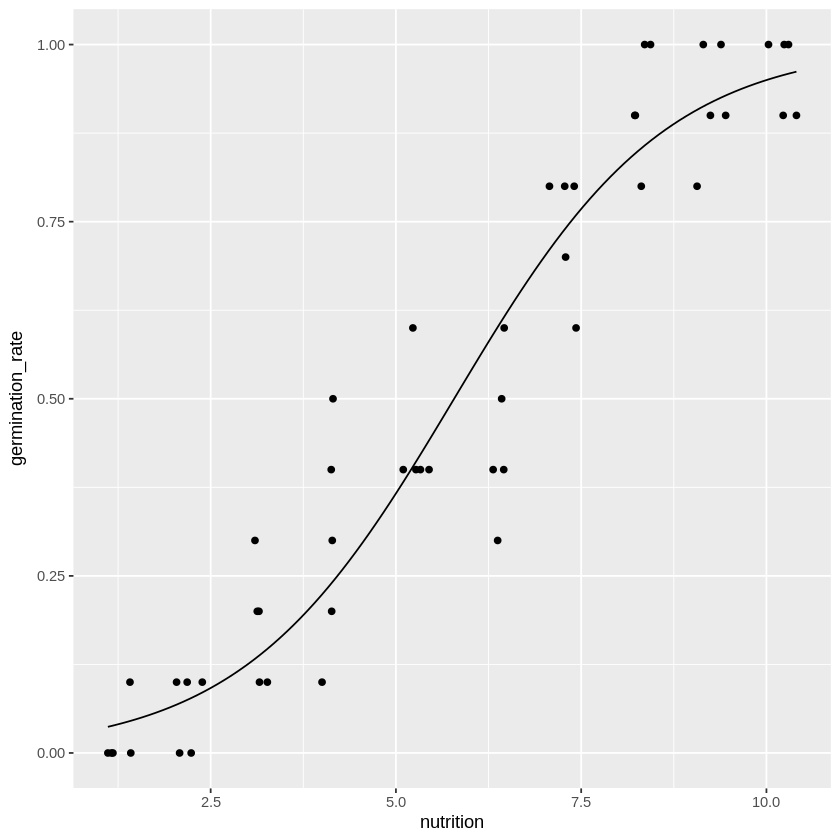

In [ ]:
# 算出したロジスティック関数を可視化する
library(ggplot2)

beta0 <- -4.03768
beta1 <- 0.69792

g <- ggplot(data=data, aes(x=nutrition, y=germination_rate))
g <- g + geom_point()
g <- g + stat_function(fun=function(x) 1/(1+exp(-(beta0+beta1*x))))
g

当てはまりの良さそうな回帰式が完成したことが分かります。

#### 説明変数の増加

今回はロジットを１つの説明変数(`nutrition`)で説明する、シンプルな回帰でした。

$log(\dfrac{p}{1-p}) = \beta_0+\beta_1x$

この回帰は、重回帰分析の時の様に、複数の説明変数で説明する様なモデルを考える事も可能です。

$log(\dfrac{p}{1-p}) = \beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_kx_k$

この場合も対数尤度$log(L)$の計算に、

$p = \dfrac{1}{1 + e^{-(\beta_0+\beta_1x_1+\beta_2x_2+\cdots+\beta_kx_k)}}$を代入して、対数尤度が最大となる$\hat{\beta_0}, \hat{\beta_1}, ..., \hat{\beta_k}$を推定します。

例えば下の様なデータがあったとします。

今回のデータは栄養成分`nutrition`だけではなく、日照条件`solar`の列も増えています。

In [ ]:
# 新しいデータセットを読み込む
data <- read.csv("https://raw.githubusercontent.com/slt666666/biostatistics_text_wed/refs/heads/main/source/_static/data/chapter9_germination2.csv")
# データを一部表示
head(data)

,germination,size,germination_rate,solar,nutrition
,<int>,<int>,<dbl>,<chr>,<dbl>
1,0,10,0,shade,1.213
2,0,10,0,shade,1.190
3,0,10,0,shade,1.199
4,0,10,0,shade,1.070
5,0,10,0,shade,1.425
6,0,10,0,shade,2.117


こちらのデータをグラフ化して、日照条件による発芽率の違いを見てみます。

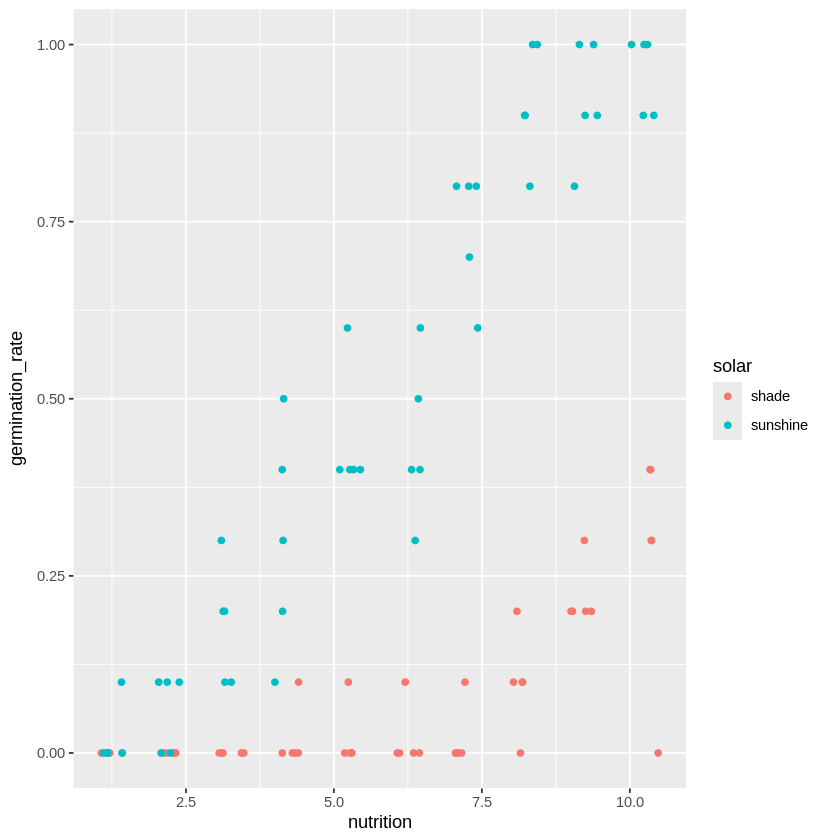

In [ ]:
# ggplotで発芽率を描写。散布図はsolarで色分けgeom_point(aes(colour=solar))
library(ggplot2)

g <- ggplot(data=data, aes(x=nutrition, y=germination_rate))
g <- g + geom_point(aes(colour=solar))
g

こうしてみると、日照条件`solar`によって発芽率の上昇度合いが変わっています。

よってモデルとしては栄養成分`nutrition`だけではなくて、日照条件`solar`も考慮した方がよさそうです。そのため、

$logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分+\beta_2 \times 日照条件$

この様な線形モデルを考える必要があります。

ここでは日照条件が`sunshine`のとき`日照条件=1`、`shade`のとき`日照条件=0`としています。

`glm`関数で入力するモデル式で説明変数を増加することでこの場合も対応できます。

In [ ]:
# 複数の説明変数を考慮したGMLをglm関数で実施
result <- glm(cbind(germination, size - germination) ~ nutrition + solar, family = binomial, data = data)
summary(result)


Call:
glm(formula = cbind(germination, size - germination) ~ nutrition + 
    solar, family = binomial, data = data)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -7.92916    0.49734  -15.94   <2e-16 ***
nutrition      0.69119    0.05114   13.52   <2e-16 ***
solarsunshine  3.93054    0.27983   14.05   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 656.621  on 99  degrees of freedom
Residual deviance:  71.132  on 97  degrees of freedom
AIC: 203.49

Number of Fisher Scoring iterations: 5


さきほどの結果と同じように

$\hat{\beta_0} = -7.92916$

$\hat{\beta_1} = 0.69119$

$\hat{\beta_2} = 3.93054$

と最尤推定量が得られました。

観測データと得られたパラメータによるロジスティック関数を両者グラフにして合わせてみると…

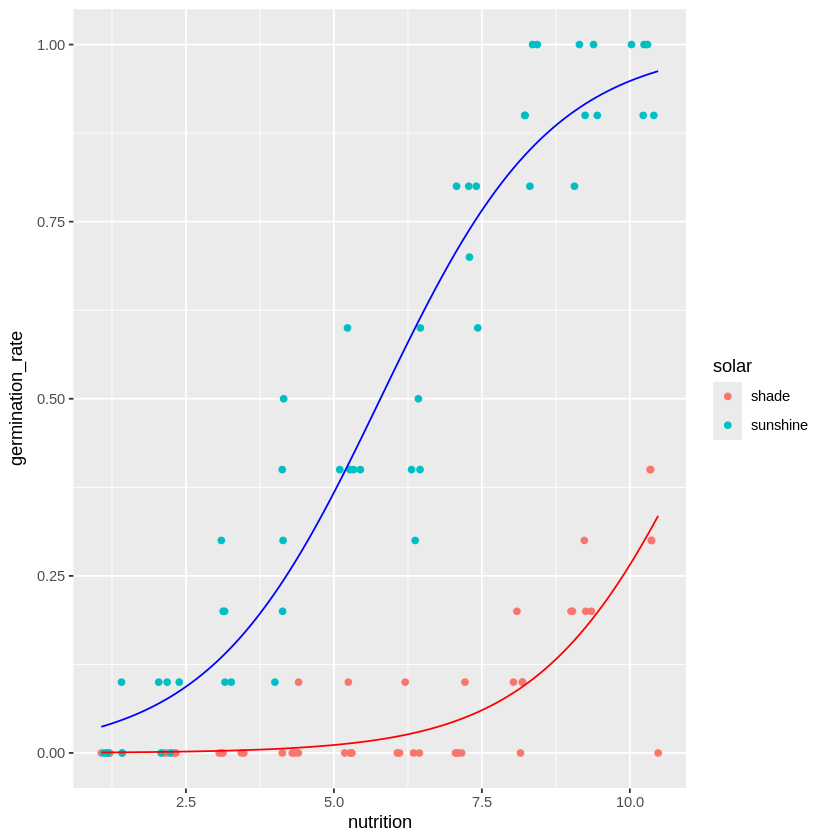

In [ ]:
# 算出したロジスティック関数を可視化する
library(ggplot2)

beta0 <- -7.92916
beta1 <- 0.69119
beta2 <- 3.93054

g <- ggplot(data=data, aes(x=nutrition, y=germination_rate))
g <- g + geom_point(aes(colour=solar))
g <- g + stat_function(fun=function(x) 1/(1+exp(-(beta0+beta1*x+beta2))), color = "blue") # sunshin条件下の回帰
g <- g + stat_function(fun=function(x) 1/(1+exp(-(beta0+beta1*x))), color = "red")        # shade条件下の回帰
g

各日照条件下で当てはまりの良さそうな回帰が実行できており、

日照条件の効果も上手く推定されていることが分かります。

### AIC (Akaike's Information Criterion)

先程の様に、全ての変数が目的変数に大きく影響していた場合、モデルに説明変数として組み込むと良いモデルが出来ました。

ただ、実際にはどんな変数が目的変数に影響を与えるのかはわからない場合が多いです。

例えば下の様なデータがあったとします。

先ほどまでの栄養成分`nutrition`、日照条件`solar`に加えて、

降水量`rain`、気温`temperature`、風速`wind`の列が追加されています。

In [ ]:
# より多数の説明変数があった場合のデータ読み込み
data <- read.csv("https://raw.githubusercontent.com/slt666666/biostatistics_text_wed/refs/heads/main/source/_static/data/chapter9_germination3.csv")
# データの一部を表示
head(data)

,germination,size,germination_rate,solar,nutrition,rain,temperature,wind
,<int>,<int>,<dbl>,<chr>,<dbl>,<int>,<int>,<int>
1,0,10,0,shade,1.213,5,20,5
2,0,10,0,shade,1.190,51,25,5
3,0,10,0,shade,1.199,61,15,1
4,0,10,0,shade,1.070,12,15,2
5,0,10,0,shade,1.425,99,20,4
6,0,10,0,shade,2.117,78,25,0


この様なデータが得られた際に、ひとまずすべてのデータをモデルに組み込んで

$logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分+\beta_2 \times 日照条件 + \beta_3 \times 降水量 + \beta_4 \times 気温 + \beta_5 \times 風速$

として計算を行ってみましょう。

実際に全ての変数を一般化線形モデルに組み込んで計算してみると...

In [ ]:
# 5つの説明変数でGLMを実施する
result <- glm(cbind(germination, size - germination) ~ nutrition + solar + rain + temperature + wind, family = binomial, data = data)
summary(result)


Call:
glm(formula = cbind(germination, size - germination) ~ nutrition + 
    solar + rain + temperature + wind, family = binomial, data = data)

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -8.7488787  0.8510836 -10.280   <2e-16 ***
nutrition      0.6960849  0.0524718  13.266   <2e-16 ***
solarsunshine  3.9683811  0.2862331  13.864   <2e-16 ***
rain           0.0021071  0.0036669   0.575    0.566    
temperature    0.0313348  0.0261608   1.198    0.231    
wind          -0.0001556  0.0663597  -0.002    0.998    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 656.621  on 99  degrees of freedom
Residual deviance:  69.142  on 94  degrees of freedom
AIC: 207.5

Number of Fisher Scoring iterations: 5


最尤推定の結果、

$logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分+\beta_2 \times 日照条件 + \beta_3 \times 降水量 + \beta_4 \times 気温 + \beta_5 \times 風速$

の$\hat{\beta_3},\hat{\beta_4},\hat{\beta_5}$が非常に小さく、発芽率とは関係ない変数である可能性が高そうです。

これは、発芽率に関係のない変数まで組み込んでしまっている、つまり実際には影響していない要因まで考慮してしまっていることになり、モデルとしては良くないモデルになっています。

<br>

実際の解析では、この**良くないモデル**というものを定量的に評価する必要があります。

例えば、今回得られたデータからは、

* 1つ目のモデル: $logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分$

* 2つ目のモデル: $logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分+\beta_2 \times 日照条件$

* 3つ目のモデル: $logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分+\beta_2 \times 日照条件 + \beta_3 \times 降水量 + \beta_4 \times 気温 + \beta_5 \times 風速$

* ...

といった形で様々なモデルを考える事が出来ました。

このうちどのモデルが良いモデルなのか選択する基準として**AIC** (**Akaike's Information Criterion**)と呼ばれる指標があります。



まず、モデルの良さを考えるときに、統計モデルのパラメータを最尤推定した時の**対数尤度**$log(L)$というものがありました。

対数尤度は「各観測データが起きうる確率の積」によって計算されたので、尤度が高ければ高いほど「"観測データ"へのあてはまりの良さ」が高いと考えられます。

最尤法では、対数尤度が最大になる様なパラメータ$\beta$が得られますが、この最大対数尤度を$log(L)^*$と表記しておきます。

この時、

$D = -2log(L)^*$

で計算される値が**逸脱度**と定義されます。

これは、値が大きいほどあてはまりが悪いことを示す値になります。

<br>

この逸脱度が小さいほど良いモデルになるのでは？という気がしてきますが、

逸脱度はどんな変数であっても変数を加えれば加えるほど小さくなっていくという特徴があります。

例えば右図の変数を大量に組み込んだ式の方がたしかに"観測データ"に対するあてはまりは良くなっていますが、その事象を説明する統計モデルとして正しいか？というと良くない可能性が高そうですね。

<img src="https://github.com/slt666666/biostatistics_text_wed/blob/main/source/_static/images/chapter9/overfit.png?raw=true" alt="title" height="200px">

よって「ある程度変数の数を抑えつつ、逸脱度は小さい」様なモデルを選択する必要があります。

この選択基準として、変数の数を$k$としたときに、

$AIC = -2(log(L)^* - k) = D + 2k$

と定義される**AIC**が良く用いられます。

このAICが一番小さいモデルが良いモデルとして選択されます。

AICは観測データへの当てはまりの良さだけでなく、モデルのパラメータ数でペナルティをつけてモデル選択することで、観測データに過剰に適合しないモデルを選択する事が出来る指標です。

Rの`glm`関数では、最尤推定を実施する際に、このAICも同時に計算してくれています。

In [ ]:
# GLMを実施し、AICを確認する
result <- glm(cbind(germination, size - germination) ~ nutrition, family = binomial, data = data)
summary(result)


Call:
glm(formula = cbind(germination, size - germination) ~ nutrition, 
    family = binomial, data = data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.82415    0.25237  -15.15   <2e-16 ***
nutrition    0.44661    0.03369   13.26   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 656.62  on 99  degrees of freedom
Residual deviance: 413.64  on 98  degrees of freedom
AIC: 544

Number of Fisher Scoring iterations: 5


では先程提示した今回のデータから考えられる3つのモデル

* 1つ目のモデル: $logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分$

* 2つ目のモデル: $logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分+\beta_2 \times 日照条件$

* 3つ目のモデル: $logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分+\beta_2 \times 日照条件 + \beta_3 \times 降水量 + \beta_4 \times 気温 + \beta_5 \times 風速$

これらのAICをそれぞれ確認してみます。

`glm`関数の結果を表示する際に、`summary(result)$aic`という形でAICのみを抽出する事が出来ます。

In [ ]:
# 3つのモデルそれぞれのAICを計算する
# 1つ目のモデル
result <- glm(cbind(germination, size - germination) ~ nutrition, family = binomial, data = data)
summary(result)$aic

# 2つ目のモデル
result <- glm(cbind(germination, size - germination) ~ nutrition + solar, family = binomial, data = data)
summary(result)$aic

# 3つ目のモデル
result <- glm(cbind(germination, size - germination) ~ nutrition + solar + rain + temperature + wind, family = binomial, data = data)
summary(result)$aic

[1] 543.9974

[1] 203.4901

[1] 207.4998

2つ目の栄養成分`nutrition`と日照条件`solar`のみ組み込んだモデルのAICが最も小さいことが分かったので、

今回は2つ目のモデルが最も良いモデルとして選択できます。

#### 他のモデル選択の指標

他によく使用されるモデル選択のための情報量基準には、**BIC**(**Bayesian Informaiton Criterion**)、ベイズ情報量基準というものがあります。

BICは最大対数尤度を$log(L)^*$、パラメータ数$k$,サンプルサイズ$n$とすると、

$BIC = -2log(L)^* + klog(n)$

で定義されます。

AICと同じように、この値を最小化するモデルを良いモデルとして選択します。

AICが新しく得られるデータの予測精度を高くするモデルを選ぶという指標であるのに対し、BICは候補となる複数の統計モデルに対し、真のモデルである確率が高いモデルが良いという指標のもと算出されます。

<br>

AICやBICは他の生物学的な解析でも登場することがあります。

例えば系統解析の際に、最適な塩基置換モデルをAICやBICで選択することがあります。

### 尤度比検定

統計モデルを比較する方法として、AICを基準とした比較以外に、**尤度比検定**と呼ばれるものもあります。

これは2つのモデルを比較し、データへの当てはまりがどれだけ改善されたかに基づいて検定を行う手法になります。

例として、先ほどの観測データに対し下の2つのモデルを比較してみます。

* 1つ目のモデル: $logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分$

* 2つ目のモデル: $logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1 \times 栄養成分+\beta_2 \times 日照条件$

このモデルを帰無仮説の枠組みで考えると、

帰無仮説: $H_0: \beta_2 = 0$

対立仮説: $H_1: \beta_2 \ne 0$

と考える事が出来ます。

この検定における統計量では、**尤度比**というものを扱います。

各モデルの最大尤度を$L_1^*, L_2^*$とすると、尤度比は$\dfrac{L_1^*}{L_2^*}$です。

この尤度比の対数を取り$-2$をかけたもの、

$𝛥D_{1,2}=-2\times(log(L_1^*)-log(L_2^*))$

を検定統計量として使用します。(**逸脱度の差**を計算していることになります。)

この$𝛥D_{1,2}$は十分なサンプルサイズがある時、自由度$1$の$\chi^2$分布に従うと近似できることが知られています。

Rでは分散分析を実施するのに用いられる`anova`関数を使用することで検定を行う事が出来ます。


In [ ]:
# anova関数を用いてモデルの尤度比検定を実施する
# 1つ目のモデル
model1 <- glm(cbind(germination, size - germination) ~ nutrition, family = binomial, data = data)

# 2つ目のモデル
model2 <- glm(cbind(germination, size - germination) ~ nutrition + solar, family = binomial, data = data)

# 尤度比検定
anova(model1, model2, test="LRT")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,98,413.63965,NA,NA,NA
2,97,71.13242,1,342.5072,1.814875e-76


このP値が有意水準$0.05$より小さいので、有意水準のもと帰無仮説($\beta_2 = 0$)が棄却される、と判断されます。

## 他の一般化線形モデルの例

ここまで、種子が発芽する確率という、二項分布に従う事象について一般化線形モデルで扱う例を見てきました。

一般化線形モデルは、誤差項が正規分布以外の分布を扱える様に拡張したモデルになり、

リンク関数(先ほどの例であればロジット関数)を使用することで線形モデルで説明できるように目的変数を変換していました。

$logit(p) = log(\dfrac{p}{1-p}) = \beta_0+\beta_1x$

<img src="https://github.com/slt666666/biostatistics_text_wed/blob/main/source/_static/images/chapter9/link_function.png?raw=true" alt="title" height="150px">

誤差項の従う分布に応じて、リンク関数も様々な関数に変わっていきます。

\begin{array}{cc} \hline
   分布 & リンク関数  \\ \hline
   正規分布 & identity: g(\mu) = \mu \\
   二項分布 & logit: g(\mu) = log\frac{\mu}{1-\mu} \\
   ポアソン分布 & log: g(\mu) = log\mu \\ \hline
\end{array}



### ポアソン分布の場合

では、別の一般化線形モデルの例として、ポアソン分布の場合を見ておきます。

今回はある地域の一定区画$1m^2$にある植物の数とその土壌水分量のデータを使用します。

In [ ]:
# 植物数のデータ読み込み
data <- read.csv("https://raw.githubusercontent.com/slt666666/biostatistics_text_wed/refs/heads/main/source/_static/data/chapter9_plant_number.csv")
# データの一部を表示
head(data)

,num,moisture
,<int>,<dbl>
1,1,13.0
2,0,10.7
3,0,8.1
4,0,5.2
5,5,22.9
6,1,5.7


このデータを可視化 + 線形モデルを描写してみると

`geom_smooth()` using formula = 'y ~ x'


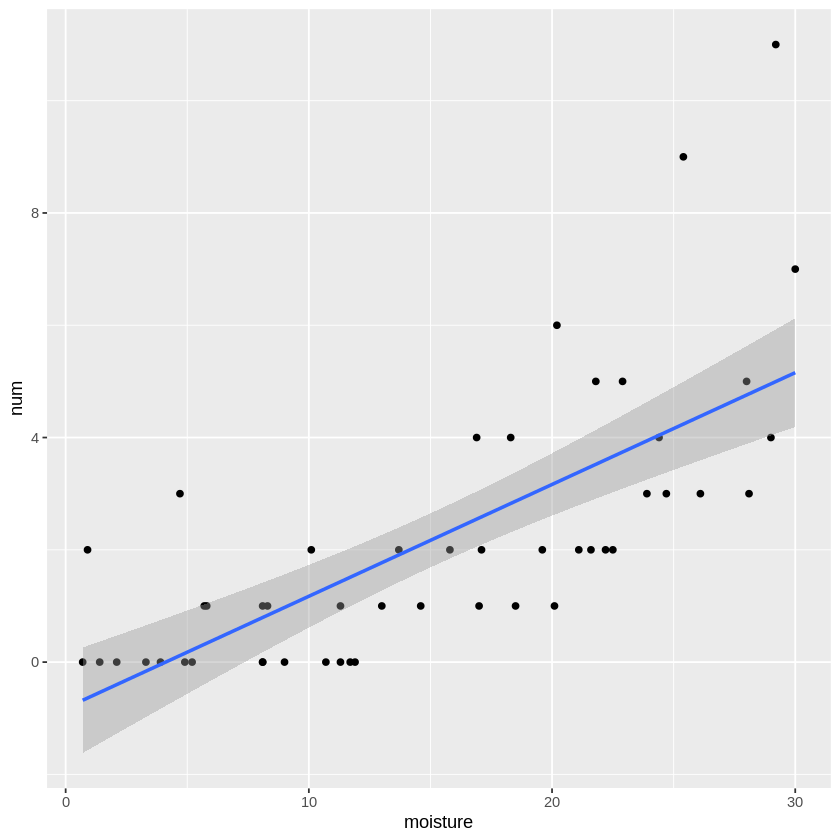

In [ ]:
# 散布図を描き、線形回帰式を描写する
library(ggplot2)

g <- ggplot(data, aes(x=moisture, y=num))
g <- g + geom_point()
g <- g + geom_smooth(method="lm")
g

通常の線形回帰でも良さそうですが、やはり細かく見ると土壌水分量が$0$の時、植物の数がマイナスになっているという問題があります。

今回の目的変数は一定区画内にある植物の数なので、必ず**0以上の離散値**をとります。

この様なカウントデータの解析では、ポアソン分布がよく用いられます。

ポアソン分布の場合のリンク関数は$log$関数になります。

$log(y) = \beta_0 + \beta_1x$

($y = e^{\beta_0 + \beta_1x}$)

カウント数は$0 \sim \infty$の範囲ですが、$log$関数を適用することで$-\infty \sim \infty$の範囲をとることになり、線形モデルが適用できます。

パラメーター$\beta_0, \beta_1$は先ほどと同じように、最尤法で推定します。

ポアソン分布では平均$\lambda$回起きる事象が$k$回起きる確率が$\dfrac{e^{-\lambda}\lambda^k}{k!}$と計算できるので、

例えば１つ目の観測データである、土壌水分量が$13.0$の時に植物の個体数が$1$の確率は

先ほどのリンク関数から$\lambda_1 = e^{\beta_0+\beta_1\times 13.0}$となり、

$\dfrac{e^{-\lambda_1}\lambda_1^1}{1!}$で計算できます。

よって各観測値それぞれの確率の積である尤度関数は

$L = \prod_{i=1}^{n}(\dfrac{e^{-\lambda_i}\lambda_i^{y_i}}{y_i!})$

と求められるので、この尤度(対数尤度)を最大にする$\beta_0, \beta_1$を求めます。

Rの`glm`関数で最尤推定を実施する場合、

```
result <- glm(モデル式, family = 目的変数の分布(link = リンク関数), data = データフレーム)
summary(result)
```

ここで目的変数の分布が`poisson`、リンク関数が今回は`log`になります。

In [ ]:
# glm関数でポアソン分布を扱う
result <- glm(num ~ moisture, family = poisson(link = "log"), data = data)
summary(result)


Call:
glm(formula = num ~ moisture, family = poisson(link = "log"), 
    data = data)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.16373    0.31234  -3.726 0.000195 ***
moisture     0.10425    0.01366   7.634 2.27e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 124.484  on 49  degrees of freedom
Residual deviance:  53.302  on 48  degrees of freedom
AIC: 157.67

Number of Fisher Scoring iterations: 5


最尤推定によって得られた$\beta_0, \beta_1$を用いて、ポアソン回帰曲線を描いてみると

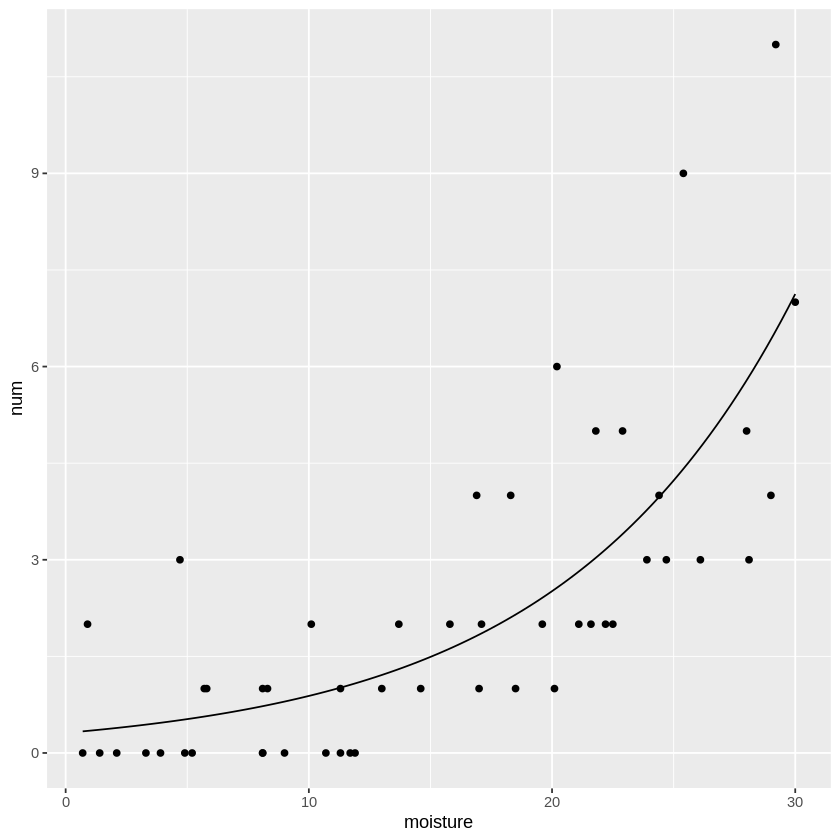

In [ ]:
# 算出したポアソン回帰曲線を可視化する
library(ggplot2)

beta0 <- -1.16373
beta1 <- 0.10425

g <- ggplot(data=data, aes(x=moisture, y=num))
g <- g + geom_point()
g <- g + stat_function(fun=function(x) exp(beta0+beta1*x))
g

この様な形で、単純な回帰直線より、よりデータに適合した回帰曲線を描く事が出来ます。

## 一般化線形混合モデル

最後に、一般化線形**混合**モデルを扱っておきます。

ここまで一般化線形モデルを扱ってきました。正規分布に従っていない場合でも、リンク関数を組み合わせることで、上手くモデルが構築できました。

しかし、実際の調査データのばらつきは、一般化線形モデルだけではうまく説明できない場合があります。

現実のデータには、データとしては観測していない個体差が存在するからです。

<img src="https://github.com/slt666666/biostatistics_text_wed/blob/main/source/_static/images/chapter9/fix_random.png?raw=true" alt="title" height="200px">

例えば、ある作物を圃場Aと圃場Bで栽培した際の種子の発芽率の違いを調査するとします。

この時、単純に考えると、最初にやった様に種子の発芽率$p$をロジット変換して、

$logit(p) = \beta_0 + 圃場の効果 \times \beta_1 + \epsilon$

というモデルで圃場の効果を考えられそうです。

圃場Aの時は$\beta_1 = 20$で圃場Bの時は$\beta_1 = 50$といった形です。

しかし実際のデータにおいては、圃場の真ん中あたりと圃場の端っこの方では環境が異なり、圃場の効果にもばらつきがあると考えられます。

この様に個体ごとに変動すると考えられる効果のことを**変量効果**と呼びます。

同じ個体を同じ条件・環境で栽培してもデータからは読み取れない何らかの原因でばらつきは生じるものです(**個体差**)。

この個体差に関しても変量効果として考える事が出来ます。

<br>

一方、ある作物に肥料を与えない時と、肥料を100g与えた時の種子の発芽数の違いを調査する場合、

「肥料を与えない」「肥料を100g与える」という処理は全個体共通で行う事が出来ると考えられるので、

肥料を100g与えた効果は$\beta_1 = 50$といった形で表せそうです。

この様な、効果を固定して考えてよいものを**固定効果**と呼びます。

<br>

この固定効果と変量効果、両者が混合しているモデルを、一般化線形**混合**モデル（Generalized Linear Mixed Model: GLMM）と呼びます。

例えば、圃場の違い($S_1$)や肥料の有無($\beta_1$)、個体差($S_0$)を組み込んだモデルを考えると

$logit(p) = \beta_0 + S_0 + X\beta_{1} + ZS_{1} + \epsilon$

といったモデルになります。

個体差$S_0$や圃場効果$S_1$は変量効果で、各個体毎に独立にばらついています。

一方で、肥料の効果$\beta_1$はどの個体でも共通の固定効果と考えています。

<br>

種子の発芽数は種子数$n$、発芽率$p$の二項分布$Bi(n, p)$に従います。

しかし、$logit(p) = \beta_0 + S_0 + X\beta_{1} + ZS_{1} + \epsilon$

には変動効果が混ざっているので、$logit(p)$もばらつくことになります。

簡単にするために、$logit(p)$が正規分布に従ってばらついていると仮定すると、$p$はロジット正規分布と呼ばれる分布に従います。(詳細は省く)

つまり、種子の発芽数は二項分布とロジット正規分布という２つの分布が混ざった分布に従うことになります。

GLMMではこの様な確率分布のパラメータをデータから最尤推定することになります。


### (参考) RでのGLMM

細かい説明は省きますが、Rでは`lme4`や`glmmML`といったパッケージでGLMMのパラメータ推定が出来ます。

今回は`lme4`を使用して見ます。Google Colabにはデフォルトでは`lme4`が無いので、インストールする必要があります。

In [ ]:
# lme4パッケージのインストール
install.packages("lme4")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rbibutils’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘Rdpack’, ‘RcppEigen’




サンプルデータとして種子の発芽データを使用します。

* 個体`plant`:1~10
* 施肥量`fertilizer`:100~500

のそれぞれの条件で種子が発芽したかどうかの反復を4回とっています。


In [ ]:
# GLMM用のデータ読み込み
data <- read.csv("https://raw.githubusercontent.com/slt666666/biostatistics_text_wed/refs/heads/main/source/_static/data/chapter9_GLMM.csv")
# データの一部を表示
head(data)

,germinate,replicate,plant,fertilizer
,<int>,<int>,<int>,<int>
1,0,1,1,100
2,0,2,1,100
3,0,3,1,100
4,0,4,1,100
5,0,1,2,100
6,1,2,2,100


施肥量`fertilizer`を固定効果として捉え、各植物`plant`毎に変量効果の個体差があるとしてGLMMを実施する場合は、

下記のような形になります。

In [ ]:
# lme4パッケージでGLMMを実施する
library(lme4)

fit.glmer <- glmer(germinate ~ fertilizer + (1|plant), data = data, family = binomial)

summary(fit.glmer)

Loading required package: Matrix



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: germinate ~ fertilizer + (1 | plant)
   Data: data

      AIC       BIC    logLik -2*log(L)  df.resid 
     43.5      48.5     -18.7      37.5        37 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4344 -0.4761  0.1457  0.3948  2.2026 

Random effects:
 Groups Name        Variance Std.Dev.
 plant  (Intercept) 2.128    1.459   
Number of obs: 40, groups:  plant, 10

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -3.734344   1.918262  -1.947   0.0516 .
fertilizer   0.014819   0.006878   2.155   0.0312 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr)
fertilizer -0.932

`Random effects`のところに、植物ごとにどのくらいばらついているかが推定され、

`Fixed effects`のところに固定効果の推定結果が出ています。

この様な形で、一般化線形モデルを使用することで、正規分布以外に従うデータに対しても解析を実施する事が出来ます。

また、一般化線形混合モデルを用いることで、変量効果や固定効果を考慮した、より現実のデータの特徴に合わせたモデル構築が実施できます。